<a href="https://colab.research.google.com/github/jimmynewland/colabnotebooks/blob/main/Answers_Equivalent_Width_Spectroscopy_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Searching for Europium using Stellar Spectroscopy


This activity allows students to explore how to find the relative abundance of a given element using the spectral features in starlight. The spectra used here were collected by teacher team in the summer of 2019 at McDonald Observatory using the Sandiford Echelle Spectrograph attached to the 2.1 meter Otto Struve Telescope. 

These spectra are part of a larger project to collect data on evolved sun-like stars with low abundances of the lanthanide elements. For more information on this class of stars, see the [PASTEL catalog](https://vizier.u-strasbg.fr/viz-bin/VizieR?-source=B/pastel) and the original paper on the PASTEL catalog [doi: 10.1051/0004-6361/201014247](http://doi.org/10.1051/0004-6361/201014247).

# Allowing your code to access your Google Drive

In [ ]:
# Allow for access to Google Sheets dataset
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

Start by saving a copy of the [data from the spreadsheet](https://docs.google.com/spreadsheets/d/e/2PACX-1vSvozaTH8wjxtIfXuS3cxDlypNQVePOHltom1jmJosvPWdLVD3daMIAFGZ_H9-COOe9W8RJMzJS2B8c/pubhtml) to your own Google Drive. If you are doing this as a group, make sure the person with the copy of the data shares access with everyone in the group so everyone can access the data.



In [ ]:
# Put the URL for your copy of the Google Sheet here.
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ns1t3TZBdeFexAfBa6DVSUkqKW6g7Gz2I48RrMmRwbM/edit#gid=1134205444')

# Importing NumPy and MatPlotLib

In [ ]:
# Import NumPy for handling our spectra data
import numpy as np

# Import SciPy for interpolating the data
from scipy.interpolate import make_interp_spline, BSpline

# This is the most common Python graphing package
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

In [ ]:
from astropy.io import fits
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()
from astropy.utils.data import download_file

In [ ]:
!pip install specutils

In [ ]:
from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.analysis import equivalent_width
from specutils.analysis import fwhm

# Copying the Data into Your Code

In [ ]:
sheet = wb.worksheet('sheet1')
data = np.array(sheet.get_all_values()[1:])
data = data.astype(np.float)
wave1 = data[:,0]
flux1 = data[:,1]
label1 = 'HD141531'

sheet = wb.worksheet('sheet2')
data = np.array(sheet.get_all_values()[1:])
data = data.astype(np.float)
wave2 = data[:,0]
flux2 = data[:,1]
label2 = 'HD165195'

sheet = wb.worksheet('sheet3')
data = np.array(sheet.get_all_values()[1:])
data = data.astype(np.float)
wave3 = data[:,0]
flux3 = data[:,1]
label3 = 'TYC5562-00446-1'

sheet = wb.worksheet('sheet4')
data = np.array(sheet.get_all_values()[1:])
data = data.astype(np.float)
wave4 = data[:,0]
flux4 = data[:,1]
label4 = 'TYC5701-00197-1'

sheet = wb.worksheet('sheet5')
data = np.array(sheet.get_all_values()[1:])
data = data.astype(np.float)
wave5 = data[:,0]
flux5 = data[:,1]
label5 = 'V*SX_Her'

"""
HD141531
HD165195
TYC5562-00446-1
TYC5701-00197-1
V*SX_Her
"""

'\nHD141531\nHD165195\nTYC5562-00446-1\nTYC5701-00197-1\nV*SX_Her\n'

# Plotting the Spectrum of Each Star

In [ ]:
def interp(w, f):
  wInterp = np.linspace(w.min(),w.max(), 300) 
  spl = make_interp_spline(w, f)
  fInterp = spl(wInterp)
  return wInterp, fInterp

In [ ]:
# Interpolate the data for smoother plots
wave1, flux1 = interp(wave1,flux1)
wave2, flux2 = interp(wave2,flux2)
wave3, flux3 = interp(wave3,flux3)
wave4, flux4 = interp(wave4,flux4)
wave5, flux5 = interp(wave5,flux5)

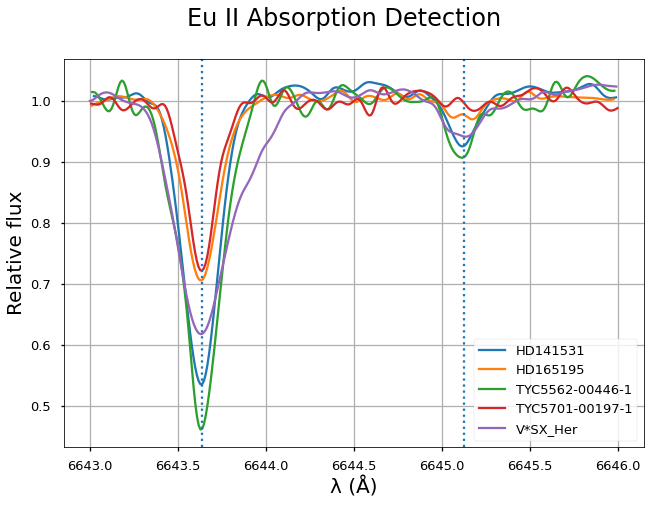

In [ ]:
fig, ax = plt.subplots()
fig.suptitle('Eu II Absorption Detection', fontsize='24')

ax.plot(wave1, flux1, label=label1)
ax.plot(wave2, flux2, label=label2)
ax.plot(wave3, flux3, label=label3)
ax.plot(wave4, flux4, label=label4)
ax.plot(wave5, flux5, label=label5)

plt.axvline(x=6645.127,ls=':')
plt.axvline(x=6643.638,ls=':')

plt.xlabel('λ (Å)',fontsize='20')
plt.ylabel('Relative flux', fontsize='20')

plt.grid(True)
ax.legend(loc='best')
plt.show()

# Determining the Equivalent Width

Using nothing more than the light from the star and some math, you can get a sense of the relative amount of a particular element in a star's atmosphere by looking at the absorption line. This is called spectroscopy and is a very important technique for analyzing light from stuff in space.

When one star has more of an element in its atmosphere than another, the absorption line will be deeper because those atoms took some of the light leaving the star and absorbed it so those photons won't make it to us.

For our data, the units are a really strange. Flux is a unit of power which is energy per time unit. Here the our flux is relative which means 1.0 would be brightest part of the light from the star and the dips are where the light is less bright because it is being absorbed. Notice the brightness varies by wavelength. That is how we are able to look for the signature of particular elements. Specific elements absorb star light at only specific wavelengths. The dips are the fingerprints of the element.

We can do this same measurement and calculation for our stars so we can compare the stars to one another.

The equivalent width calculation is fairly simple geometry that comes from some [very complicated stellar physics and chemistry](http://research.iac.es/congreso/itn-gaia2013/media/Primas2.pdf).

$ W_{\lambda}\propto\ Nhf\lambda^2 $



# Full-Width at Half Max

In order to find the relative abundance, you need to find the equivalent width, and in order to do that, you'll need to find the full-width at half-max (FWHM). Notice the inverted bell-curve shape in the spectrum which indicates an absorption line for a particular element, in this case this is one of the lines associated with Nickel. Since the curve is upside down for our absorption region, we need to find the minimum y-value rather than the maximum. Once we know the minimum value in the flux (y-axis), we can divide by 2 for the half-max bit. Then we can use the 2 wavelengths (x-axis) where the curve has that associated half-max flux value (y-axis) to find the equivalent width.

The equivalent width is the difference between the 2 wavelengths where the data goes through the halfway point of the range of the flux.

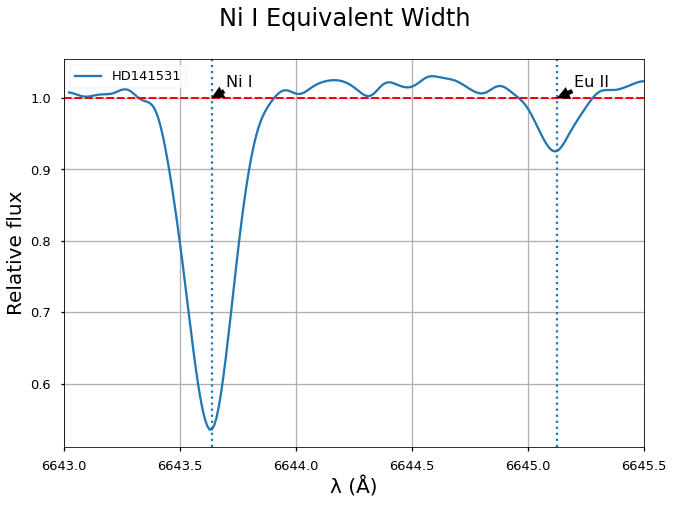

In [ ]:
fig2, ax2 = plt.subplots()

fig2.suptitle('Ni I Equivalent Width', fontsize='24')

ax2.plot(wave1, flux1, label=label1)

plt.xlabel('λ (Å)',fontsize='20')
plt.ylabel('Relative flux', fontsize='20')

ax2.set_xlim([6643,6645.5])

plt.axvline(x=6643.638,ls=':')
plt.axvline(x=6645.127,ls=':')

ax2.annotate('Ni I', xy=(6643.638, 1), xytext=(6643.7, 1.015),arrowprops=dict(facecolor='black'), fontsize='16')
plt.axhline(y=1,ls='--',color='red',lw=2)

ax2.annotate('Eu II',xy=(6645.127, 1), xytext=(6645.2, 1.015),arrowprops=dict(facecolor='black'), fontsize='16')
plt.axhline(y=1,ls='--',color='red',lw=2)

plt.grid(True)
ax2.legend(loc='best')
plt.show()

# Finding the Equivalent Width with SpecUtils

In [ ]:
# Add units to the fluxes and wavelengths
flux1 = flux1*u.Unit('erg cm-2 s-1 AA-1') 
wave1 = wave1*u.AA

flux2 = flux2*u.Unit('erg cm-2 s-1 AA-1') 
wave2 = wave2*u.AA

flux3 = flux3*u.Unit('erg cm-2 s-1 AA-1') 
wave3 = wave3*u.AA

flux4 = flux4*u.Unit('erg cm-2 s-1 AA-1') 
wave4 = wave4*u.AA

flux5 = flux5*u.Unit('erg cm-2 s-1 AA-1') 
wave5 = wave5*u.AA

In [ ]:
spec1 = Spectrum1D(spectral_axis=wave1, flux=flux1)
spec2 = Spectrum1D(spectral_axis=wave2, flux=flux2)
spec3 = Spectrum1D(spectral_axis=wave3, flux=flux3)
spec4 = Spectrum1D(spectral_axis=wave4, flux=flux4)
spec5 = Spectrum1D(spectral_axis=wave5, flux=flux5)

In [ ]:

print('Ni I EW\t\tEu II EW\tEu/Ni\tName')
ni1 = equivalent_width(spec1, regions=SpectralRegion(6643.0*u.AA,6644*u.AA))
eu1 = equivalent_width(spec1, regions=SpectralRegion(6644.7*u.AA,6645.5*u.AA))
r1 = eu1/ni1

ni2 = equivalent_width(spec2, regions=SpectralRegion(6643.0*u.AA,6644*u.AA))
eu2 = equivalent_width(spec2, regions=SpectralRegion(6644.7*u.AA,6645.5*u.AA))
r2 = eu2/ni2

ni3 = equivalent_width(spec3, regions=SpectralRegion(6643.0*u.AA,6644*u.AA))
eu3 = equivalent_width(spec3, regions=SpectralRegion(6644.7*u.AA,6645.5*u.AA))
r3 = eu3/ni3

ni4 = equivalent_width(spec4, regions=SpectralRegion(6643.0*u.AA,6644*u.AA))
eu4 = equivalent_width(spec4, regions=SpectralRegion(6644.7*u.AA,6645.5*u.AA))
r4 = eu4/ni4

ni5 = equivalent_width(spec5, regions=SpectralRegion(6643.0*u.AA,6644*u.AA))
eu5 = equivalent_width(spec5, regions=SpectralRegion(6644.7*u.AA,6645.5*u.AA))
r5 = eu5/ni5

#Rounding
ni1 = np.round(ni1,4)
eu1 = np.round(eu1,4)
r1 = np.round(r1,3)
print(str(ni1)+'\t'+str(eu1)+'\t'+str(r1)+'\t'+label1)

ni2 = np.round(ni2,4)
eu2 = np.round(eu2,4)
r2 = np.round(r2,3)
print(str(ni2)+'\t'+str(eu2)+'\t'+str(r2)+'\t'+label2)

ni3 = np.round(ni3,4)
eu3 = np.round(eu3,4)
r3 = np.round(r3,3)
print(str(ni3)+'\t'+str(eu3)+'\t'+str(r3)+'\t'+label3)

ni4 = np.round(ni4,4)
eu4 = abs(np.round(eu4,4))
r4 = abs(np.round(r4,3))
print(str(ni4)+'\t'+str(eu4)+'\t'+str(r4)+'\t'+label4)

ni5 = np.round(ni5,4)
eu5 = np.round(eu5,4)
r5 = np.round(r5,3)
print(str(ni5)+'\t'+str(eu5)+'\t'+str(r5)+'\t'+label5)

Ni I EW		Eu II EW	Eu/Ni	Name
0.1102 Angstrom	0.0066 Angstrom	0.06	HD141531
0.0716 Angstrom	0.0034 Angstrom	0.048	HD165195
0.1429 Angstrom	0.0161 Angstrom	0.113	TYC5562-00446-1
0.0585 Angstrom	0.0009 Angstrom	0.016	TYC5701-00197-1
0.142 Angstrom	0.0122 Angstrom	0.086	V*SX_Her
